In [1]:
# Make sure all dependencies are installed
#!pip install -r requirements.txt

# 0 - Imports

In [2]:
import seaborn as sns
import pandas as pd
import mlflow
import mlflow.sklearn
import math
import numpy as np
from dill import load
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.decomposition import PCA
from xgboost import XGBRegressor 
from bayes_opt import BayesianOptimization
from datetime import datetime

In [3]:
#this class and structure to load/store the data helps me to always have the most 
#up to day data, plus the version of the data, mostly to record as part of the
#experiment and training pipeline
from utils.data_loader_tools import DataLoader
#this is where I store info related to the dataset, 
#where to obtain it from, define the version 
#(this is for the case that it can be stracted from source, 
#in this case is fixed to 01.00.00)
from data.data_configs.nir_spectra import specs as nir_spectra_specs


# 1 - Data load

In [4]:
#create the object to load the data
data_loader = DataLoader(nir_spectra_specs)
raw_data, version = data_loader.load_lastest()

data_metadata = {nir_spectra_specs['technical_name']:{'version':version,
                                                      'shape':raw_data.shape,
                                                      'ingestion_date':datetime.now().strftime("%Y%m%d%H%M%S")}}
data_metadata

{'nir_spectra': {'version': '01.00.00',
  'shape': (3908, 681),
  'ingestion_date': '20210718165636'}}

In [5]:
#here is where I store the learnings while exploring the data
meta_artifact_documentation = set()


In [6]:
meta_artifact_documentation.add(f'''
[OBSERVATION][ASSUMPTION]
The ratio of rows/columns is low: {raw_data.shape}
if not treated properly it could result in overfitting''')

# 1-1 Create holdout set before the EDA

In [7]:
X_explore, X_test, y_explore, y_test = train_test_split(raw_data.drop('target',axis=1), 
                                                    raw_data['target'], 
                                                    test_size=0.15, #  over 500 samples
                                                    random_state=314)

meta_artifact_documentation.add(f'''
[ASSUMPTION]
as I do not have information on the overall population that was used to take these samples from, I will assume that a
 A random set will be representative of the universe
 ''')

# 2 - initial target exploration

In [8]:
y_explore.describe()

count    3321.000000
mean       31.230516
std        20.146884
min         3.060644
25%        13.090000
50%        22.654310
75%        51.264366
max        76.603981
Name: target, dtype: float64

<AxesSubplot:xlabel='target', ylabel='Count'>

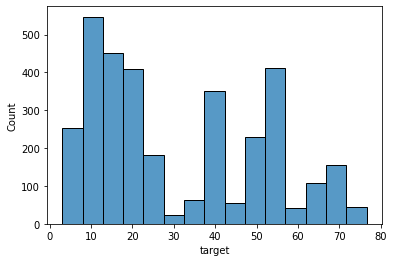

In [9]:
sns.histplot(y_explore)

In [10]:
meta_artifact_documentation.add(f'''
target variable seems to not have any null values 
[QUESTION] is the data preprocesed?''')

In [11]:
meta_artifact_documentation.add(f'''
[DOMAIN] 
target variable seems to not have faulty data, 
this should be verified with a domain expert''')

In [12]:
meta_artifact_documentation.add(f'''
[OBSERVATION][ASSUMPTION]
the distribution of the target has 4 clearly defined groups, 
this might be useful  to search for specific patterns in these 4 groups
also, it might be helpful to see if the final model is weaker for some of these groups
The first group: (0-30) has the majority of the data
The other groups seem to be (30-45), (45-60), (60-)''')
#there are better ways to determine the groups: clustering, fitting a multinomial distribution

In [13]:
meta_artifact_documentation.add(f'''
[EXPECTATION]
target value should always be numeric
target value should always be greater than 0
target value is expected to be under 80
''')

In [14]:
support_data_train = pd.DataFrame(y_explore.copy())
support_data_train['group'] = None
support_data_train.loc[support_data_train.target<30,'group'] = 1
support_data_train.loc[(support_data_train.target>=30)&(support_data_train.target<45),'group'] = 2
support_data_train.loc[(support_data_train.target>=45)&(support_data_train.target<60),'group'] = 3
support_data_train.loc[support_data_train.target>=60,'group'] = 4
support_data_train.group.value_counts()

1    1862
3     707
2     443
4     309
Name: group, dtype: int64

# 3- Initial feature exploration

In [15]:
meta_artifact_documentation.add(f'''
[ASSUMPTION]
Spectral data is represented by having a value for every wavelength, 
each wavelength is represented in a different column
I assume that any column to the right to another column represents a higher wavelength 
''')


<AxesSubplot:ylabel='id'>

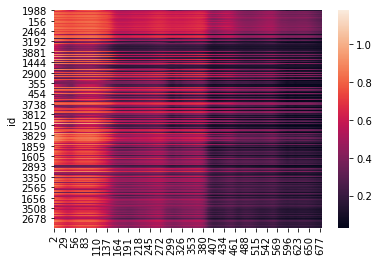

In [16]:
sns.heatmap(X_explore.loc[y_explore.sort_values().index,:])

In [17]:
meta_artifact_documentation.add(f'''
[OBSERVATION]
it looks like most/almost-all samples follow a similar pattern on its peaks and valleys  
5-7 peaks
this is observed in the heatmap as vertical "shadows"
''')

meta_artifact_documentation.add(f'''
[ASSUMPTION]
All the samples seem to be of the same material/element. 
Given how the shape of the data for each sample resemble to each other
''')

meta_artifact_documentation.add(f'''
[OBSERVATION]
samples seem to have an overall consistency across all wavelengths for high and low values.
Meaning that "lower" spectrum tend to remain "lower" across the whole spectrum.
this is noticed in the heatmap as horizontal "stripes"
''')


meta_artifact_documentation.add(f'''
[DOMAIN]
validate with domain expert if this behavior of having spectra that have the same shape but the different scale is normal for this type of data
''')

meta_artifact_documentation.add(f'''
[DOMAIN][ASSUMPTION][OBSERVATION]
The only potential quality issue that I could observe in this dataset is related to the "scale" of each spectra.
Based on my research, my assumption is that the difference in scale between the different spectra of the two samples is most likely caused by environmental factors during the measuring process.''')

In [18]:
#lets check a general description of all values in the training set
#this woulnt make any sense in a dataset that contains different units for the values in the different columns
X_explore.describe().T.describe()

count        mean         std         min         25%         50%  \
count   680.0  680.000000  680.000000  680.000000  680.000000  680.000000   
mean   3321.0    0.393885    0.141431    0.120863    0.274141    0.388603   
std       0.0    0.144299    0.018529    0.074355    0.129586    0.168100   
min    3321.0    0.174023    0.093797    0.030424    0.097728    0.151241   
25%    3321.0    0.269505    0.123756    0.061885    0.161725    0.245293   
50%    3321.0    0.410245    0.143773    0.118303    0.285628    0.404729   
75%    3321.0    0.464022    0.156323    0.151557    0.349790    0.467968   
max    3321.0    0.675904    0.177743    0.259916    0.563432    0.720031   

              75%         max  
count  680.000000  680.000000  
mean     0.524183    0.720698  
std      0.156784    0.197818  
min      0.262553    0.403849  
25%      0.374840    0.537181  
50%      0.552418    0.706239  
75%      0.596230    0.782232  
max      0.815916    1.177857

In [19]:
(X_explore>1).sum().sum()

1827

In [20]:
meta_artifact_documentation.add(f'''
[OBSERVATION]
there are several values in the training data that are greater than 1''')

<AxesSubplot:ylabel='id'>

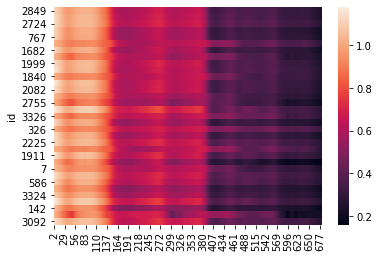

In [21]:
_aux = X_explore[(X_explore>1).sum(axis=1)>0]
sns.heatmap(_aux)

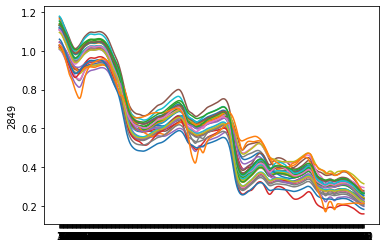

In [22]:
[sns.lineplot(x=_aux.columns, y=_aux.loc[r,:]) for r in _aux.index]
None

In [23]:
# these spectra do not seem to have particarly unusual beheavour

In [24]:
meta_artifact_documentation.add(f'''
[ASSUMPTION]
The values represented in the columns are not %
This negates any expectation of values being <1
''')

meta_artifact_documentation.add(f'''
[EXPECTATION]
I expect values for the spectra to be >0
''')


# 4 - explore data transformation 
## for analysis and feature creation

### 4.1 - rescale spectra by spectra mean

In [25]:
#Lets now try to normalize the data, first on row level

In [26]:
support_data_train['mean'] = X_explore.mean(axis=1)
_X_explore_scaled = X_explore.apply(lambda r: r/r.mean(), axis=1)

target      mean
target  1.000000 -0.066139
mean   -0.066139  1.000000

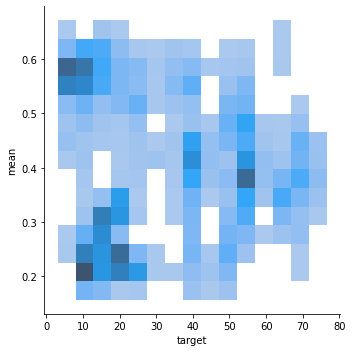

In [27]:
sns.displot(data=support_data_train, x='target', y='mean')
support_data_train.corr()

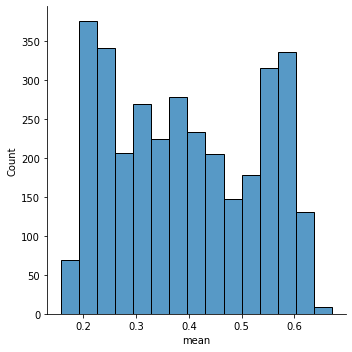

In [28]:
sns.displot(support_data_train['mean'])

In [29]:
meta_artifact_documentation.add(f'''
[OBSERVATION]
There is almost no correlation between the target and the mean value per row.
I will not use the mean of the spectra for this analysis. 
But it could be a candidate to store as an extra feature.
''')

<AxesSubplot:ylabel='id'>

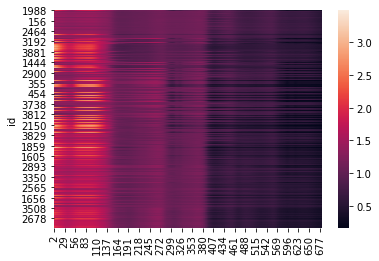

In [30]:
_aux_sort_target = y_explore.sort_values().index
sns.heatmap(_X_explore_scaled.loc[_aux_sort_target,:])

In [31]:

meta_artifact_documentation.add(f'''
[OBSERVATION]
I do not observe any noteworthy pattern between the mean normalised spectra and the target''')

<AxesSubplot:ylabel='id'>

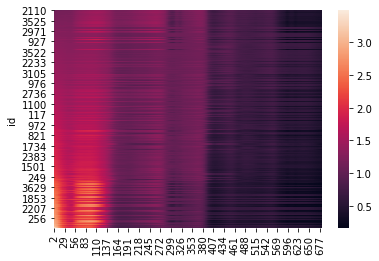

In [32]:
_aux_sort_max= _X_explore_scaled.iloc[:,0].sort_values().index
sns.heatmap(_X_explore_scaled.loc[_aux_sort_max,:])

In [33]:
meta_artifact_documentation.add(f'''
[OBSERVATION]
I observe that some spectra are more prone to "skip" some peaks
or to have less pronounced peaks''')

### 4.2 - normalize spectra by wavelength 

In [34]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(_X_explore_scaled)
_X_explore_normalised = _X_explore_scaled.copy()
_X_explore_normalised = pd.DataFrame(scaler.transform(_X_explore_scaled), 
                                   index=_X_explore_scaled.index, 
                                   columns=_X_explore_scaled.columns)

<AxesSubplot:ylabel='id'>

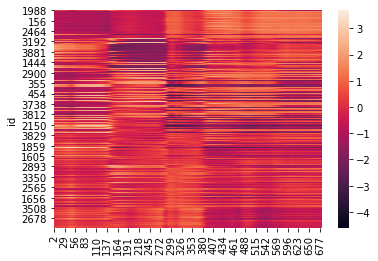

In [35]:
_aux_sort_target = y_explore.sort_values().index
sns.heatmap(_X_explore_normalised.loc[_aux_sort_target,:])

In [36]:
meta_artifact_documentation.add(f'''
[OBSERVATION]
visually, there seem to be more patterns when using a spectra-scaled, wavelength-noramalised dataset''')

# 4.3 - Derivate

In [37]:
meta_artifact_documentation.add(f'''
[ASSUMPTION] [DOMAIN]
the effects of specific chemical components on a NIR spectra, affect specific wavelengths, not the overall spectra.
Assuming we are looking for a set of specific components, analyzing how the derivate(on wavelength) relates to the target might prove to be beneficial''')

In [38]:
_X_explore_normalised_dev = _X_explore_normalised.diff(axis=1).dropna(axis=1)

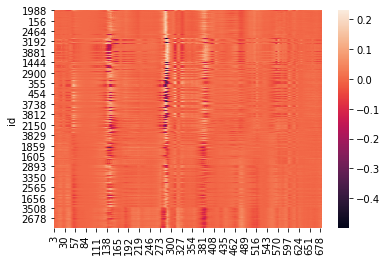

In [39]:
_aux_sort_target = y_explore.sort_values().index
sns_plot=sns.heatmap(_X_explore_normalised_dev.loc[_aux_sort_target,:])
sns_plot.figure.savefig('images/heatmap_derivate.png') 

In [40]:
meta_artifact_documentation.add(f'''
[OBSERVATION]
there are specific frequencies that seem to capture the majority of the information''')

# 5 - Baseline

My approach to solve this problem will be to test minor improvements and see the effects inmediatelly.
For this Im going to start by defining a validation set, and then create a simple, and very dumb baseline model,
for every decision/ improvement, I will compare the results with the baseline, and in case it proves to be an improvement, I will update which one is my baseline model

In [41]:
X_train, X_validate, y_train, y_validate = train_test_split(X_explore, 
                                                            y_explore, 
                                                            test_size=0.15, #  almost 500 samples
                                                            random_state=314)

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    perc_75_ape = (abs(pred-actual)/actual * 100).quantile(.75)
    perc_99_ape = (abs(pred-actual)/actual * 100).quantile(.99)
    return rmse, mae, r2, perc_75_ape, perc_99_ape

In [43]:
meta_artifact_documentation.add(f'''
[ASSUMPTION][DOMAIN]
usually, a good way to advertise model performance is by mentioning how often it gets "things right".
The metric that has worked for me in the past is median absolute percentage error
this essentially says: for 50% of our results we have less than X% error in our prediction.
Given that this problem seems to rely on high accuracy, I will use 75% and 95% percentiles for absolute percent error''')

In [44]:
# dumb linear model

mlflow.set_experiment('simple_linear_regresion')
with mlflow.start_run():
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)

    mlflow.log_dict( data_metadata, 'data_metadata.json')
    
    #in-sample metrics
    predicted_values = lr.predict(X_train)
    (rmse, mae, r2,  perc_75_ape, perc_99_ape) = eval_metrics(y_train, predicted_values)
    print('metrics for in-sample predictions:','rmse',rmse, 'mae',mae, 'r2',r2, 'perc_75_ape', perc_75_ape, 'perc_99_ape', perc_99_ape)
    mlflow.log_metric("is_rmse", rmse)
    mlflow.log_metric("is_r2", r2)
    mlflow.log_metric("is_mae", mae)
    mlflow.log_metric("is_perc_75_ape", perc_75_ape)
    mlflow.log_metric("is_perc_99_ape", perc_99_ape)
    
    #validation metrics
    predicted_values = lr.predict(X_validate)
    (rmse, mae, r2,  perc_75_ape, perc_99_ape) = eval_metrics(y_validate, predicted_values)
    print('metrics for the validation set:','rmse',rmse, 'mae',mae, 'r2',r2, 'perc_75_ape', perc_75_ape, 'perc_99_ape', perc_99_ape)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("perc_75_ape", perc_75_ape)
    mlflow.log_metric("perc_99_ape", perc_99_ape)
    
    
    
    mlflow.sklearn.log_model(lr, "model")

metrics for in-sample predictions: rmse 1.2020893922624822 mae 0.9312747330116184 r2 0.9964322206450223 perc_75_ape 6.014020748266963 perc_99_ape 28.85681788748249
metrics for the validation set: rmse 1.5897627285819005 mae 1.2168867223279145 r2 0.9938202499004394 perc_75_ape 8.091137340718031 perc_99_ape 37.294216126994264


# 5.1 - Analysais of results

In [45]:
_aux = pd.DataFrame(y_validate)
_aux['pred'] = predicted_values

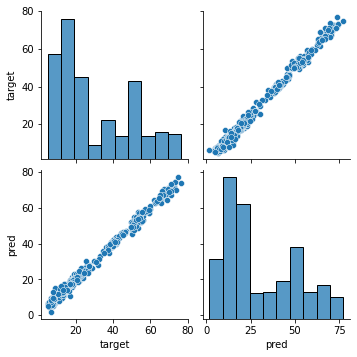

In [46]:
sns.pairplot(_aux)

In [47]:
meta_artifact_documentation.add(f'''
[OBSERVATION]
The simple linear model seems to perform better than expected,
Despite this being the situation, Linear models have shortcomings that I will try to circumvent.
2 of these shortcomings being: not resilient to null values, sensitive to single value errors
''')

In [48]:
meta_artifact_documentation.add(f'''
[FUTURE]
When trying to acieve certain levels of precision, infrmation about the data generation process is needed.
This way we can train the model to be more resiliat to certain type of noise
And also to understand what are the theorical limits of the model peformance
''')

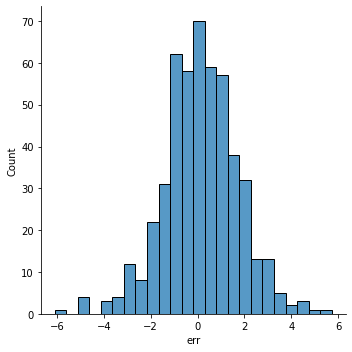

In [49]:
_aux['err'] = (_aux['pred']-_aux['target'])
_aux['err_abs'] = (_aux['pred']-_aux['target']).abs()
_aux['err_rel'] = (_aux['pred']-_aux['target'])/_aux['target']

sns.displot(_aux['err'] )

<AxesSubplot:xlabel='target', ylabel='err'>

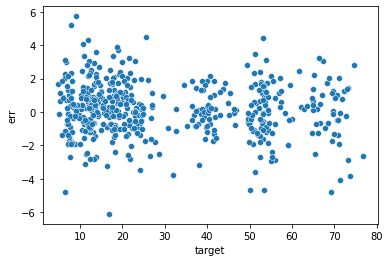

In [50]:
sns.scatterplot(x=_aux['target'] ,y=_aux['err'])

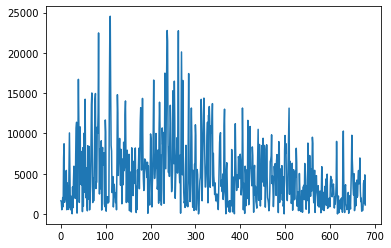

In [51]:
sns_plot = sns.lineplot(x=range(len(lr.coef_)), y=abs(lr.coef_))
sns_plot.figure.savefig('images/lm_importance_abs.png') 

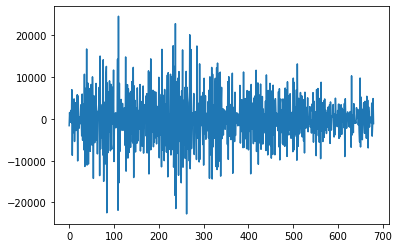

In [52]:
sns_plot=sns.lineplot(x=range(len(lr.coef_)), y=lr.coef_)
sns_plot.figure.savefig('images/lm_importance.png') 

In [53]:
meta_artifact_documentation.add(f'''
[OBSERVATION]
Some wavelengths seem to be more important than others, 
but the feature "importance" is not as equally distributed across nearby wavelengths
it could be a good idea to add regularization
''')

# 6 - Add data preprocessing

In [54]:
mlflow.set_experiment('simple_linear_regresion_with_preprocessing')


In [55]:
with mlflow.start_run():
    
    mlflow.log_dict( data_metadata, 'data_metadata.json')

    #create the data processing pipeline
    ppl_derivate = Pipeline(steps = [
        #first the row scaler, 
        ('row_scaler',FunctionTransformer(lambda X: X.apply(lambda r: r/r.mean(), axis=1) )),
        #normalise each wavelength
        ('column_normalizer', StandardScaler()),
        #derivate each row to find "jumpy" wavelengths
        ('row_derivation',FunctionTransformer(lambda X:  pd.DataFrame(X).diff(axis=1).dropna(axis=1)))
    ])
    
    ppl_derivate.fit(X_train)
    
    #lets analyse the preprocessing in isolation by mantaining the same model
    lr = linear_model.LinearRegression()
    _X_train_transformed = ppl_derivate.transform(X_train)
    _X_train_transformed.index = X_train.index
    
    lr.fit(_X_train_transformed, y_train)
        
    #in-sample metrics
    predicted_values = lr.predict(_X_train_transformed)
    
    (rmse, mae, r2,  perc_75_ape, perc_99_ape) = eval_metrics(y_train, predicted_values)
    print('metrics for in-sample predictions:','rmse',rmse, 'mae',mae, 'r2',r2, 'perc_75_ape', perc_75_ape, 'perc_99_ape', perc_99_ape)
    mlflow.log_metric("is_rmse", rmse)
    mlflow.log_metric("is_r2", r2)
    mlflow.log_metric("is_mae", mae)
    mlflow.log_metric("is_perc_75_ape", perc_75_ape)
    mlflow.log_metric("is_perc_99_ape", perc_99_ape)
    
    #validation metrics
    _X_transformed = ppl_derivate.transform(X_validate)
    _X_transformed.index = X_validate.index

    predicted_values = lr.predict(_X_transformed)
    (rmse, mae, r2,  perc_75_ape, perc_99_ape) = eval_metrics(y_validate, predicted_values)
    print('metrics for the validation set:','rmse',rmse, 'mae',mae, 'r2',r2, 'perc_75_ape', perc_75_ape, 'perc_99_ape', perc_99_ape)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("perc_75_ape", perc_75_ape)
    mlflow.log_metric("perc_99_ape", perc_99_ape)
    
    
    mlflow.sklearn.log_model(lr, "model")

metrics for in-sample predictions: rmse 1.1631189794465118 mae 0.9001258332899426 r2 0.9966597979092916 perc_75_ape 5.7500932787310735 perc_99_ape 25.87385896737433
metrics for the validation set: rmse 1.6673834843295419 mae 1.2625403297082023 r2 0.9932020607015387 perc_75_ape 8.416733069586499 perc_99_ape 42.675675666295234


<AxesSubplot:xlabel='target', ylabel='err'>

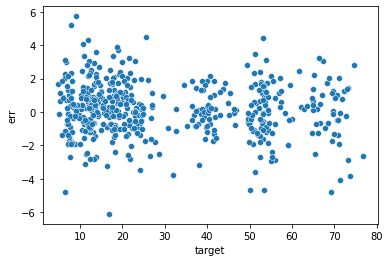

In [56]:
sns.scatterplot(x=_aux['target'] ,y=_aux['err'])

<AxesSubplot:>

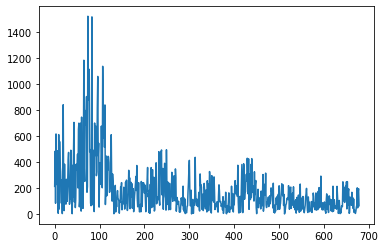

In [57]:
sns.lineplot(x=range(len(lr.coef_)), y=abs(lr.coef_))

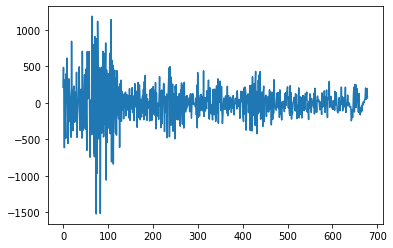

In [58]:
sns_plot=sns.lineplot(x=range(len(lr.coef_)), y=lr.coef_)
sns_plot.figure.savefig('images/lm_preprocessed_importance.png') 

In [59]:
meta_artifact_documentation.add(f'''
[OBSERVATION]
With the preprocessing,  and linear model
The overall performance did not improve, it actually decreased on the validation set.
on the other hand, the effect of different features seems to be better represented,
Also, the training vs test error is wider in this case, it might be that we are overfitting.
''')


# 7 - Final modeling effort

In [60]:
# a natural next step would be to test a model with regularization.
# Instead I will skip some modeling iterations and try xgboost to maximise the performance,
# it is a well known model, that has good performance, tools for explainability, is able to handle null values, and is not as sensible to single value outliers
# I imagine overfitting being a problem, preprocessing would be key, for that I will try PCA

# The main reason why I like aproaching modeling on incremental steps of added complexity 
# is to gain the added bennefit of understanding the data based on model results, parameters and hyperparameters

In [61]:
mlflow.set_experiment('xgboost_and_pca')

In [62]:
# as part of this lets try different preprocessing methods and consider this selection part of hypertuning

## 7.1 - Define pre-processing methods for hyperparamenter tunning
I plan to let the hpt to selec wich method is the best one,
for this I present 4 options\
1 - simple normalization\
2 - normalization, derivation\
3 - normalization, pca\
4 - normalization, derivation, pca

In [63]:
preprocessing_pipelines = {}

In [64]:
ppl_normalization = Pipeline(steps = [
    #first the row scaler, 
    ('row_scaler',FunctionTransformer(lambda X: X.apply(lambda r: r/r.mean(), axis=1) )),
    #normalise each wavelength
    ('column_normalizer', StandardScaler()),
    #to dataframe
    ('to_pandas',FunctionTransformer(lambda X: pd.DataFrame(X)))
])

preprocessing_pipelines['normalization'] = ppl_normalization

In [65]:
ppl_derivate = Pipeline(steps = [
    #first the row scaler, 
    ('row_scaler',FunctionTransformer(lambda X: X.apply(lambda r: r/r.mean(), axis=1) )),
    #normalise each wavelength
    ('column_normalizer', StandardScaler()),
    #derivate each row to find "jumpy" wavelengths
    ('row_derivation',FunctionTransformer(lambda X:  pd.DataFrame(X).diff(axis=1).dropna(axis=1)))
])

preprocessing_pipelines['normalization_derivate'] = ppl_derivate

In [66]:
params = {'dimensionality_reduction':{'n_components':.999, #aims to get explained variance to 99.9 or greater
                                      'svd_solver':'full'}}

__pca = PCA(**params['dimensionality_reduction']) 

ppl_dim_reduction = Pipeline(steps = [
        #first the row scaler, 
        ('row_scaler',FunctionTransformer(lambda X: X.apply(lambda r: r/r.mean(), axis=1) )),
        #normalise each wavelength
        ('column_normalizer', StandardScaler()),
        #create
        ('dimensionality_reduction', __pca)  ,
        #to dataframe
        ('to_pandas',FunctionTransformer(lambda X: pd.DataFrame(X)))  
 ])

preprocessing_pipelines['normalization_dim_reduction'] = ppl_dim_reduction

In [67]:
params = {'dimensionality_reduction':{'n_components':.999, #aims to get explained variance to 99.9 or greater
                                      'svd_solver':'full'}}


__pca = PCA(**params['dimensionality_reduction']) 

ppl_derivate_dim_reduction = Pipeline(steps = [
    #first the row scaler, 
    ('row_scaler',FunctionTransformer(lambda X: X.apply(lambda r: r/r.mean(), axis=1) )),
    #normalise each wavelength
    ('column_normalizer', StandardScaler()),
    #derivate each row to find "jumpy" wavelengths
    ('row_derivation',FunctionTransformer(lambda X:  pd.DataFrame(X).diff(axis=1).dropna(axis=1))),
    #create
    ('dimensionality_reduction', __pca) ,
    #to dataframe
    ('to_pandas',FunctionTransformer(lambda X: pd.DataFrame(X)))   
])

preprocessing_pipelines['normalization_derivate_dim_reduction'] = ppl_derivate_dim_reduction

## 7.2 - define hyper parameters ranges 

In [68]:
def transform_nr_to_pipeline(nr, _dict):
    '''
    This function is a hack that translates a number into a discrete element to be used in the model
    This is needed because the bayesian otpmiser does not work with categorical features
    nr: number between 0 and 4-eps
    '''
    floor_value = math.floor(nr)
    element_key = list(_dict.keys())[floor_value]
    element_value = _dict[element_key]
    return element_value, element_key
        
def train_evaluate_record(n_estimators,
                          learning_rate,
                          gamma,
                          max_depth,
                          min_child_weight,
                          subsample,
                          preprocessing_method):
    '''
    This function runs a whole experiment based on initial paramenters
    '''
    with mlflow.start_run():
        #Log all inputs and paramenters before training
        mlflow.log_dict( data_metadata, 'data_metadata.json')
        mlflow.log_params({'n_estimators':int(n_estimators),
                          'learning_rate':learning_rate,
                          'gamma':gamma,
                          'max_depth':int(max_depth),
                          'min_child_weight':min_child_weight,
                          'subsample':subsample})
        mlflow.log_params(params)
        
        #### PREPROCESSING: DEFINE, FIT AND TRANSFORM 
        # get the pre-processing pipeline object that is going to be used
        ppl, key = transform_nr_to_pipeline(preprocessing_method, preprocessing_pipelines)
        mlflow.log_param('preprocessing_method',key)
        ppl.fit(X_train)
        
        _X_train_transformed = ppl.transform(X_train)
        _X_train_transformed.index = X_train.index
        
        #### MODEL: DEFINE, FIT 
        # get the pre-processing pipeline object that is going to be used
        
        model = XGBRegressor(n_estimators=int(n_estimators),
                               learning_rate=learning_rate,
                               gamma=gamma,
                               max_depth=int(max_depth),
                               min_child_weight=min_child_weight,
                               subsample=subsample)

        model.fit(_X_train_transformed, y_train)



        #### RUN MODEL IN TRAINING SET TO GET METRICS
        predicted_values = model.predict(_X_train_transformed)

        (is_rmse, is_mae, is_r2,  is_perc_75_ape, is_perc_99_ape) = eval_metrics(y_train, predicted_values)
        mlflow.log_metric("is_rmse", is_rmse)
        mlflow.log_metric("is_r2", is_r2)
        mlflow.log_metric("is_mae", is_mae)
        mlflow.log_metric("is_perc_75_ape", is_perc_75_ape)
        mlflow.log_metric("is_perc_99_ape", is_perc_99_ape)

        #### RUN PIPELINE AND MODEL IN VALIDATION SET TO GET METRICS
        _X_transformed = ppl.transform(X_validate)
        _X_transformed.index = X_validate.index

        predicted_values = model.predict(_X_transformed)
        (rmse, mae, r2,  perc_75_ape, perc_99_ape) = eval_metrics(y_validate, predicted_values)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("perc_75_ape", perc_75_ape)
        mlflow.log_metric("perc_99_ape", perc_99_ape)

        #### if everything else worked out, save the model
        mlflow.sklearn.log_model(model, "model")

    return -perc_99_ape
# the choice of minimising perc_99_ape for the hyperparameter tuning, 
# is that the model on its own is going to try to minimise mse,
# if we select hyperparameters also to optimise the same metric we might end up 
# overoptimizing for that metric only, and passing the oportunity of 
# optimises for a hollistic high performance.

In [69]:

pbounds = {'n_estimators':(1,500),
           'learning_rate': (0, 1),
           'gamma': (0, 1),
           'max_depth':(0,20),
           'min_child_weight':(0,50),
           'subsample':(0.1, 1),
           'preprocessing_method': (0,len(preprocessing_pipelines)-0.01)
          }

optimizer = BayesianOptimization(
    f=train_evaluate_record,
    pbounds=pbounds,
    random_state=314,
)

# used this as reference
# https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning


## 7.3 - run experiments

In [70]:
#this is written in this way mostly for the purpose of speeding up development and debugging
#while running the optimiser I had to debug and re-run a few times, so instead of creating a new optimiser
#I wanted to leverage the previous runs. This way we only create a new optimiser when we run the notebook for the first time
#or when I decide to create a new one in another cell

#another way to deal with this would be to save the optimiser as an artifact
#or to use mlflow param storage to get the previous runs and all the performance metrics
#and create a "cache"-like function that bypasses the actuall training and just loads the final metric
#into the optimiser. that would be a fast way to have the new optimiser "up to speed" with what was learned before
try:
    optimizer.maximize()
except:
    optimizer = BayesianOptimization(
        f=train_evaluate_record,
        pbounds=pbounds,
        random_state=314,
    )
    optimizer.maximize()

|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... | prepro... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -47.79    |  0.9169   |  0.5885   |  5.301    |  39.16    |  459.1    |  3.301    |  0.7552   |
|  2        | -105.9    |  0.2605   |  0.9118   |  5.215    |  38.32    |  131.5    |  0.4879   |  0.4474   |
|  3        | -75.19    |  0.8401   |  0.2782   |  1.398    |  31.66    |  292.8    |  2.319    |  0.7095   |
|  4        | -43.04    |  0.6872   |  0.4389   |  6.419    |  28.53    |  240.4    |  3.436    |  0.8513   |
|  5        | -73.73    |  0.1058   |  0.06041  |  11.94    |  39.62    |  114.0    |  2.135    |  0.2225   |
|  6        | -42.99    |  0.7468   |  0.347    |  7.617    |  27.72    |  227.5    |  3.335    |  0.9551   |
|  7        | -40.97    |  0.5718   |  0.1303   |  4.186    |  37.55    |  458.7    |  2.794    |  0.433    |
|  8      

In [71]:
optimizer.max

{'target': -34.270524898688436,
 'params': {'gamma': 0.2338208845930967,
  'learning_rate': 0.43107420894064097,
  'max_depth': 3.333928831815347,
  'min_child_weight': 44.732853467336206,
  'n_estimators': 463.1815472365004,
  'preprocessing_method': 1.8568471817978485,
  'subsample': 0.7936208024816175}}

## 7.4 - analysing results and final selection

In [72]:
#I choose first the eperiment with the most runs, so I can select the best results from this set
mlflow.set_experiment('xgboost_and_pca')

In [73]:
%%capture
# here I get all the experiments in a dafatrame and I carete a dataframe with results and metrics
runs = mlflow.search_runs()
runs = runs.set_index('run_id', drop=True)
finished_runs = runs[runs['status'] == 'FINISHED']
run_metrics = finished_runs[finished_runs.columns[finished_runs.columns.str.contains('metrics')]].copy()
validation_metrics = run_metrics[run_metrics.columns[~ run_metrics.columns.str.contains('is_')]].copy()
# I do 1-r2 just so for all metrics now in the dataframe, lower means better
validation_metrics.loc[:,'metrics.r2'] = 1 - validation_metrics.loc[:,'metrics.r2']

In [74]:
#here I plan to create a ranking based on the sum of the percentiles for each metric
# if one model is the worst in each metric, the expected score would be 500
# if one model is the best in each metric the expected score would be close to 0

experiment_metric_scores = validation_metrics.apply(lambda col: col.apply(lambda elem: stats.percentileofscore(col,elem)))
exeriment_overall_score = experiment_metric_scores.sum(axis=1).sort_values()

experiment_ranking = exeriment_overall_score.reset_index()\
.reset_index()\
.rename(columns={0:'score',
                 'index':'ranking'})\
.set_index('run_id')

# I add a ranking column to make it easy to sort and identify
run_metrics.loc[:,'ranking'] = experiment_ranking.loc[:,'ranking'].copy()
run_metrics.loc[:,'score'] = experiment_ranking.loc[:,'score']
run_metrics = run_metrics.sort_values('ranking')

In [75]:
run_metrics.head(5)

metrics.is_mae  metrics.is_perc_99_ape  \
run_id                                                                     
077b7d0c67ab43f3b1c0ebecf31a496c        0.328617               12.452929   
2a227baa82e7438a9ecb6805a251399e        0.423021               12.411644   
4ec78bc8aa8045668904d4d4f041b199        0.136443                4.221613   
f742ad56a70a4d4cb3eebedccf1096db        0.136443                4.221613   
c73499d265ef449b94816b108eb4f9ae        0.176072                5.502336   

                                  metrics.is_r2  metrics.mae  metrics.r2  \
run_id                                                                     
077b7d0c67ab43f3b1c0ebecf31a496c       0.999447     0.885046    0.996255   
2a227baa82e7438a9ecb6805a251399e       0.999232     1.044560    0.994878   
4ec78bc8aa8045668904d4d4f041b199       0.999922     1.013020    0.994458   
f742ad56a70a4d4cb3eebedccf1096db       0.999922     1.013020    0.994458   
c73499d265ef449b94816b108eb4f9ae       0.999870     1.090561    0.993822   

                                  metrics.is_perc_75_ape  metrics.perc_99_ape  \
run_id                                                                          
077b7d0c67ab43f3b1c0ebecf31a496c                2.005574            26.382616   
2a227baa82e7438a9ecb6805a251399e                2.573611            31.723894   
4ec78bc8aa8045668904d4d4f041b199                0.879466            29.491920   
f742ad56a70a4d4cb3eebedccf1096db                0.879466            29.491920   
c73499d265ef449b94816b108eb4f9ae                1.129994            34.270525   

                                  metrics.rmse  metrics.is_rmse  \
run_id                                                            
077b7d0c67ab43f3b1c0ebecf31a496c      1.237599         0.473101   
2a227baa82e7438a9ecb6805a251399e      1.447367         0.557871   
4ec78bc8aa8045668904d4d4f041b199      1.505466         0.177648   
f742ad56a70a4d4cb3eebedccf1096db      1.505466         0.177648   
c73499d265ef449b94816b108eb4f9ae      1.589587         0.229591   

                                  metrics.perc_75_ape  ranking      score  
run_id                                                                     
077b7d0c67ab43f3b1c0ebecf31a496c             5.695943        0   2.923977  
2a227baa82e7438a9ecb6805a251399e             6.431317        1   8.187135  
4ec78bc8aa8045668904d4d4f041b199             6.917446        2  10.233918  
f742ad56a70a4d4cb3eebedccf1096db             6.917446        3  10.233918  
c73499d265ef449b94816b108eb4f9ae             6.794041        4  14.912281

In [76]:
# when comparing these models with the original linear models (see next cells) 
# it becomes clear that the xgboost models end up pefromrming better.

In [77]:
def get_metrics_from_run(run_name):
    mlflow.set_experiment(run_name)
    runs = mlflow.search_runs()
    runs = runs.set_index('run_id', drop=True)
    finished_runs = runs[runs['status'] == 'FINISHED']
    run_metrics = finished_runs[finished_runs.columns[finished_runs.columns.str.contains('metrics')]].copy()
    return run_metrics

In [98]:
get_metrics_from_run('simple_linear_regresion')

metrics.is_mae  metrics.is_perc_99_ape  \
run_id                                                                     
043b845b986f41ad840bf3679a1b05ae        0.931275               28.856818   

                                  metrics.is_r2  metrics.mae  metrics.r2  \
run_id                                                                     
043b845b986f41ad840bf3679a1b05ae       0.996432     1.216887     0.99382   

                                  metrics.is_perc_75_ape  metrics.perc_99_ape  \
run_id                                                                          
043b845b986f41ad840bf3679a1b05ae                6.014021            37.294216   

                                  metrics.rmse  metrics.is_rmse  \
run_id                                                            
043b845b986f41ad840bf3679a1b05ae      1.589763         1.202089   

                                  metrics.perc_75_ape  
run_id                                                 
043b845b986f41ad840bf3679a1b05ae             8.091137

In [99]:
get_metrics_from_run('simple_linear_regresion_with_preprocessing')

metrics.is_mae  metrics.is_perc_99_ape  \
run_id                                                                     
3455d67019e74c588e9a721391c763f1        0.900126               25.873859   

                                  metrics.is_r2  metrics.mae  metrics.r2  \
run_id                                                                     
3455d67019e74c588e9a721391c763f1        0.99666      1.26254    0.993202   

                                  metrics.is_perc_75_ape  metrics.perc_99_ape  \
run_id                                                                          
3455d67019e74c588e9a721391c763f1                5.750093            42.675676   

                                  metrics.rmse  metrics.is_rmse  \
run_id                                                            
3455d67019e74c588e9a721391c763f1      1.667383         1.163119   

                                  metrics.perc_75_ape  
run_id                                                 
3455d67019e74c588e9a721391c763f1             8.416733

# 8 - Results and conclussion

In [80]:
mlflow.set_experiment('xgboost_and_pca')
run = mlflow.get_run(run_metrics[run_metrics['ranking']==0].index[0])
run_id = run.info.run_id

pipeline = preprocessing_pipelines[run.data.params['preprocessing_method']]
pipeline = pipeline.fit(X_train)


# Load model as a PyFuncModel.
model = f'runs:/{run_id}/model'
model = mlflow.pyfunc.load_model(model)


#now lets run the model on the test set to have a final test on the holdout set
y_test_hat = model.predict(pipeline.transform(X_test))

(rmse, mae, r2,  perc_75_ape, perc_99_ape) = eval_metrics(y_test, y_test_hat)

print('rmse: \t\t',rmse)
print('mae: \t\t',mae)
print('r2: \t\t',r2)
print('perc_75_ape: \t',perc_75_ape)
print('perc_99_ape: \t',perc_99_ape)



rmse: 		 1.251122735148063
mae: 		 0.8775260795051327
r2: 		 0.9958638874972943
perc_75_ape: 	 4.961362753182236
perc_99_ape: 	 27.577049511174884


In [81]:
run.data.params

{'dimensionality_reduction': "{'n_components': 0.999, 'svd_solver': 'full'}",
 'gamma': '0.5453309985163823',
 'learning_rate': '0.10049679722768767',
 'max_depth': '14',
 'min_child_weight': '48.921467501474766',
 'n_estimators': '155',
 'preprocessing_method': 'normalization_derivate',
 'subsample': '0.6966096497050743'}

# 8.1 - Error analysis

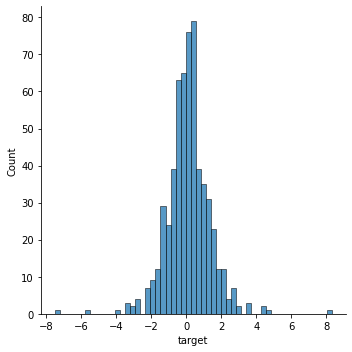

In [82]:
sns.displot(y_test_hat-y_test)

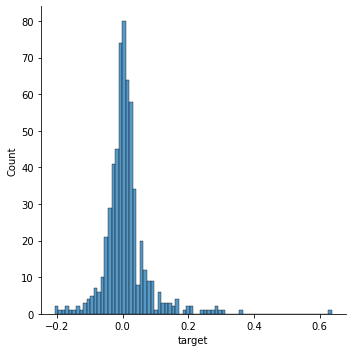

In [83]:
sns.displot((y_test_hat-y_test) / y_test)

<AxesSubplot:xlabel='target', ylabel='target'>

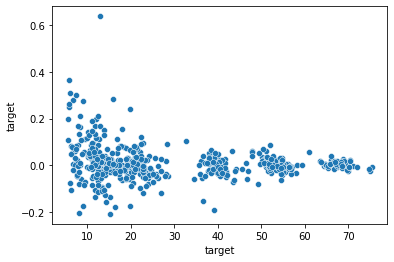

In [84]:
sns.scatterplot(y=(y_test_hat-y_test)/ y_test, x=y_test)

<AxesSubplot:xlabel='target', ylabel='target'>

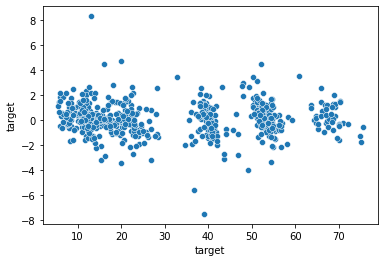

In [85]:
sns.scatterplot(y=(y_test_hat-y_test), x=y_test)

The final results seem to have a consistent absolute error for different values of target, 

this, of course, makes the percentage error bigger for smaller values of target

In [86]:
meta_artifact_documentation.add(f'''
[OBSERVATION]
after observing the final results, I am reconsidering the choice of measuring quantile_absolute_percentage_error 
instead of quantile_absolute_error. 
One of the main reasons why to use this metric is for the ease of explainability,
in retrospect, for this problem, the absolute error makes more sense than the percent error
''')


# 8-2 feature importance

In [90]:
model = load(open(f"mlruns/{mlflow.get_experiment_by_name('xgboost_and_pca').experiment_id}/{run_id}/artifacts/model/model.pkl",'rb'))

<AxesSubplot:>

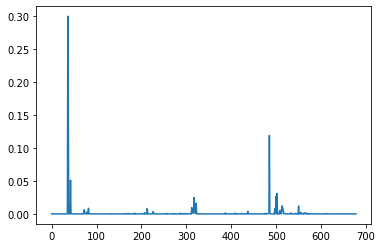

In [91]:
sns.lineplot(y=model.feature_importances_, x=range(len(model.feature_importances_)))

In [92]:
meta_artifact_documentation.add(f'''
[OBSERVATION][DOMAIN]
It is very clear from the final feature importance analysis
that there is a very small subset of the features (after pre-processing) that have an impact on the result.
based on this would be good to validate with a domain expert if those specific wavelengths are usually responsible for having an effect on our target value.
Also, this validates some of the initial explorations where the peaks seemed to be the points of most interest
''')


In [93]:
feature_importance = pd.Series(model.feature_importances_.copy(), index=pipeline.transform(X_train).columns)
feature_importance = feature_importance.sort_values(ascending=False).reset_index().rename(columns={'index':'col_name',0:'importance'})

In [94]:
feature_importance.head(15).sort_values('col_name')

col_name  importance
0         37    0.300168
1         38    0.201230
3         43    0.051169
13       313    0.009527
6        318    0.024797
12       319    0.009547
9        320    0.012083
7        323    0.016348
2        486    0.119212
5        501    0.027300
4        503    0.031160
8        514    0.012235
11       515    0.009837
14       516    0.008861
10       551    0.011979

In [95]:
meta_artifact_documentation.add(f'''
[OBSERVATION]
The most important features tend to belong to the bands (based on column index)
[37-43] band
[313-323] band
[486] spike
[501-516] band
[551] spike
''')


# 8-3 save results

In [96]:
from datetime import datetime
from dill import dump


import os
now = datetime.now().strftime("%Y%m%d%H%M%S")
path = f'model_artifacts/{now}/'
os.makedirs(os.path.dirname(path))

# datetime object containing current date and time
# save the model
dump(model, open(f'model_artifacts/{now}/model.pkl', 'wb'))
# save the pipeline
dump(pipeline, open(f'model_artifacts/{now}/data_pipeline.pkl', 'wb'))


In [97]:
dump(meta_artifact_documentation, open('exploration_coments_artifact.pkl','wb'))